In [22]:
#!pip install pytorch torchvision cudatoolkit=10.1 -c pytorch

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import torch
import torch.nn as nn

In [13]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention,self).__init__()
    self.embed_size=embed_size
    self.heads=heads
    self.head_dim=embed_size//heads

    assert(self.head_dim*heads==embed_size),"Embed size needs to be div by heads"
    
    self.values=nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.keys=nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.queries=nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.fc_out=nn.Linear(heads*self.head_dim, embed_size)
  def forward(self,values,keys,query,mask):
    N=query.shape[0]
    value_len,key_len,query_len=values.shape[1],keys.shape[1],query.shape[1]

    #split embedding into self.heads pieces
    values=values.reshape(N,value_len,self.heads,self.head_dim)
    keys=keys.reshape(N,key_len,self.heads,self.head_dim)
    queries=query.reshape(N,query_len,self.heads,self.head_dim)

    values=self.values(values)
    keys=self.keys(keys)
    queries=self.queries(queries)
    energy=torch.einsum("nqhd,nkhd->nhqk",[queries,keys])
    #queries shape: (N,query_len, heads, heads_dim)
    #keys shape: (N,key_len, heads, heads_dim)
    #energy shape: (N,heads,query_len,key_len)
    if mask is not None:
      energy=energy.masked_fill(mask==0,float("-1e20"))#close it ,0
    attention=torch.softmax(energy/(self.embed_size**(1/2)),dim=3)#softmax
    out=torch.einsum("nhql,nlhd->nqhd",[attention,values]).reshape(N,query_len,self.heads*self.head_dim)
    #attention shape: (N,heads, query_len,key_len)
    #values shape: (N,value_len,heads,head_dim)#key_len=value_len=l
    #after einsum(N,query_len,heads,head_dim) then flatten last two dim

    out=self.fc_out(out)
    return out

## TransformerBlock

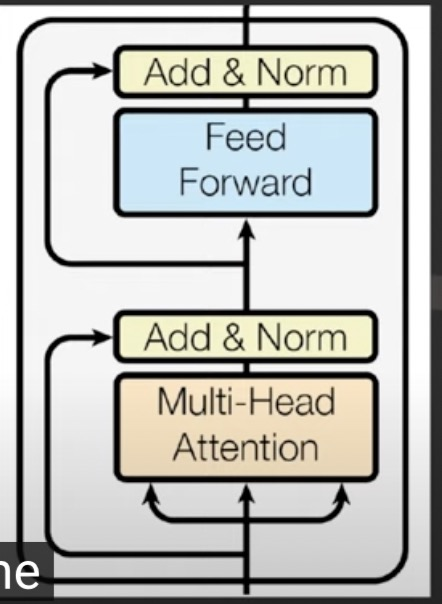

In [14]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size,heads,dropout,forward_expansion):
    super(TransformerBlock,self).__init__()
    self.attention=SelfAttention(embed_size,heads)
    self.norm1=nn.LayerNorm(embed_size)
    self.norm2=nn.LayerNorm(embed_size)

    self.feed_forward=nn.Sequential(
        nn.Linear(embed_size, forward_expansion*embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size,embed_size)
    )
    self.dropout=nn.Dropout(dropout)
  def forward(self,values,keys,query,mask):
    attention=self.attention(values,keys,query,mask)
    x=self.dropout(self.norm1(attention+query))
    forward=self.feed_forward(x)
    out=self.dropout(self.norm2(forward+x))
    return out

In [15]:
class Encoder(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      embed_size,
      num_layers,
      heads,
      device,
      forward_expansion,
      dropout,
      max_length):
    super(Encoder,self).__init__()
    self.embed_size=embed_size
    self.device=device
    self.word_embedding=nn.Embedding(src_vocab_size,embed_size)
    self.position_embedding=nn.Embedding(max_length,embed_size)
    self.layers=nn.ModuleList(
        [
         TransformerBlock(
             embed_size,
             heads,
             dropout=dropout,
             forward_expansion=forward_expansion
         ) for _ in range(num_layers)
        ]
    )
    self.dropout=nn.Dropout(dropout)
  def forward(self,x,mask):
    N,seq_length=x.shape
    positions=torch.arange(0,seq_length).expand(N,seq_length).to(self.device)

    out=self.dropout(self.word_embedding(x)+self.position_embedding(positions))
    for layer in self.layers:
      out=layer(out,out,out,mask)   #key,query,value all the same
    return out

## DecoderBlock

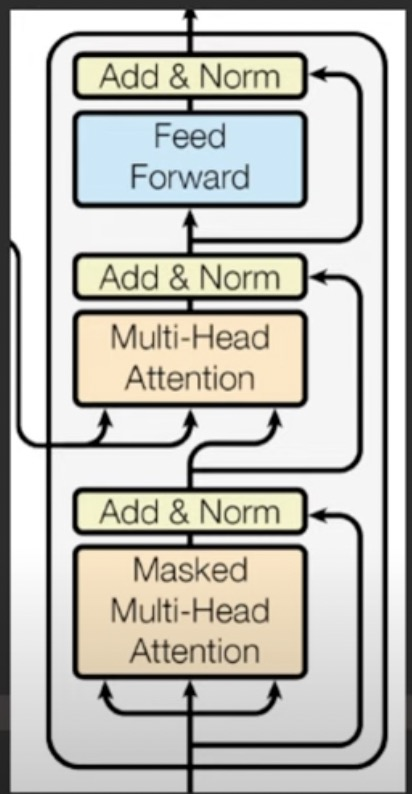

In [16]:
class DecoderBlock(nn.Module):
  def __init__(self, embed_size,heads,dropout,forward_expansion,device):
    super(DecoderBlock,self).__init__()
    self.attention=SelfAttention(embed_size,heads)
    self.norm=nn.LayerNorm(embed_size)
    self.transformer_block=TransformerBlock(
        embed_size, heads, dropout, forward_expansion
    )
    self.dropout=nn.Dropout(dropout)
  def forward(self,x,value,key,src_mask,trg_mask):
    #source mask and target mask
    attention=self.attention(x,x,x,trg_mask)#trg_mask is the mask mult-headed attention the first one in decoder block
    query=self.dropout(self.norm(attention+x))
    out=self.transformer_block(value,key,query,src_mask)
    return out

## Decoder

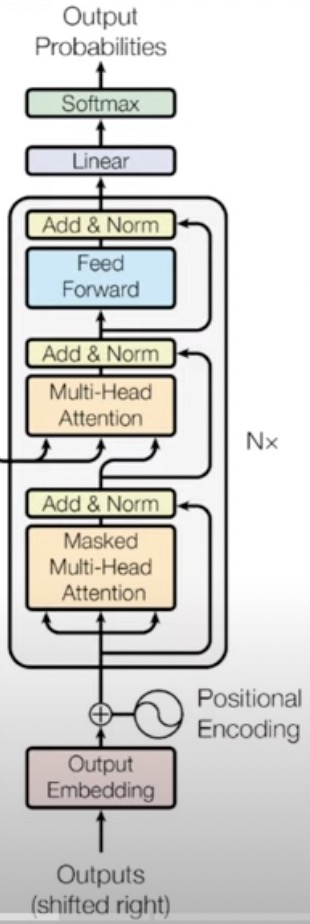

In [17]:
class Decoder(nn.Module):
  def __init__(self,
               trg_vocab_size,
               embed_size,
               num_layers,
               heads,
               forward_expansion,
               dropout,
               device,
               max_length):
    super(Decoder,self).__init__()
    self.device=device
    self.word_embedding=nn.Embedding(trg_vocab_size,embed_size)
    self.position_embedding=nn.Embedding(max_length,embed_size)
    self.layers=nn.ModuleList(
        [DecoderBlock(embed_size,heads,dropout,forward_expansion,device) for _ in range(num_layers)]
    )

    self.fc_out=nn.Linear(embed_size,trg_vocab_size)
    self.dropout=nn.Dropout(dropout)
  def forward(self,x,enc_out,src_mask,trg_mask):
    N,seq_length=x.shape
    positions=torch.arange(0,seq_length).expand(N,seq_length).to(self.device)

    out=self.dropout(self.word_embedding(x)+self.position_embedding(positions))
    for layer in self.layers:
      x=layer(x,enc_out,enc_out,src_mask,trg_mask)#def forward(self,x,value,key,src_mask,trg_mask): value same as key
    out=self.fc_out(x)
    return out

In [18]:
class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size=256,
      num_layers=6,
      forward_expansion=4,
      heads=8,
      dropout=0,
      device="cuda",
      max_length=100):
    super(Transformer,self).__init__()
    self.encoder=Encoder(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length
    )
    self.decoder=Decoder(
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length
    )
    self.src_pad_idx=src_pad_idx
    self.trg_pad_idx=trg_pad_idx
    self.device=device
  def make_src_mask(self,src):
    src_mask=(src!= self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    #(N,1,1,src_len)
    return src_mask.to(self.device)
  def make_trg_mask(self,trg):
    N,trg_len=trg.shape
    trg_mask=torch.tril(torch.ones((trg_len,trg_len))).expand(
        N,1,trg_len,trg_len
    )
    return trg_mask.to(self.device)
  def forward(self,src,trg):
    src_mask=self.make_src_mask(src)
    trg_mask=self.make_trg_mask(trg)
    enc_src=self.encoder(src,src_mask)
    out=self.decoder(trg, enc_src,src_mask, trg_mask)
    return out


In [19]:
if __name__=="__main__":
  device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

  x=torch.tensor([[1,5,6,4,3,9,5,2,0],[1,8,7,3,4,5,6,7,2]]).to(
      device
  )
  trg=torch.tensor([[1,7,4,3,5,9,2,0],[1,5,6,2,4,7,6,2]]).to(device)

  src_pad_idx=0
  trg_pad_idx=0
  src_vocab_size=10
  trg_vocab_size=10
  model=Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(
      device
  )
  out=model(x,trg[:,:-1])
  print(out.shape)

RuntimeError: ignored